In [324]:
import pandas as pd
import json
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from joblib import parallel_backend
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

galaxy_data = pd.read_csv("data/clean_data.csv")
all_inputs = galaxy_data.drop(columns=["subclass"]).values

galaxy_data_normalized = pd.read_csv("data/clean_data_normalized.csv")
all_inputs_normalized = galaxy_data_normalized.drop(columns=["subclass"]).values

all_labels = galaxy_data["subclass"].values
nr_features = all_inputs.shape[1]

In [325]:
(
    training_inputs, 
    testing_inputs, 
    training_classes, 
    testing_classes
) = train_test_split(all_inputs, all_labels, test_size=0.25)

In [326]:
(
    training_inputs_normalized,
    testing_inputs_normalized,
    training_classes_normalized,
    testing_classes_normalized,
) = train_test_split(all_inputs_normalized, all_labels, test_size=0.25)

In [327]:
under_sampler = RandomUnderSampler()
inputs_under_sampl, labels_under_sampl = under_sampler.fit_resample(
    all_inputs, all_labels
)
inputs_under_sampl_normalized, labels_under_sampl_normalized = (
    under_sampler.fit_resample(all_inputs_normalized, all_labels)
)

In [328]:
over_sampler = RandomOverSampler()
inputs_over_sampl, labels_over_sampl = over_sampler.fit_resample(all_inputs, all_labels)
inputs_over_sampl_normalized, labels_over_sampl_normalized = over_sampler.fit_resample(
    all_inputs_normalized, all_labels
)

In [329]:
(
    training_inputs_under_sampl_normalized,
    testing_inputs_under_sampl_normalized,
    training_classes_under_sampl_normalized,
    testing_classes_under_sampl_normalized,
) = train_test_split(inputs_under_sampl_normalized, labels_under_sampl_normalized, test_size=0.25)

In [330]:
(
    training_inputs_over_sampl_normalized,
    testing_inputs_over_sampl_normalized,
    training_classes_over_sampl_normalized,
    testing_classes_over_sampl_normalized,
) = train_test_split(inputs_over_sampl_normalized, labels_over_sampl_normalized, test_size=0.25)

In [331]:
def json_to_dict(filename):
    with open(filename, "r") as f:
        return json.load(f)

best_params = json_to_dict("best_params.json")

In [332]:
def train_classifier(
    classifier,
    data,
    labels,
):
    with parallel_backend("loky"):
        classifier.fit(data, labels)
    print("Classifier trained")

    return classifier

In [333]:
def print_classification_report(
    model, testing_inputs, testing_classes, filename=None, show_feature_importances=True
):
    # plot histogarm with feature importance
    if show_feature_importances:
        plt.bar(
            galaxy_data.drop(columns=["subclass"]).columns, model.feature_importances_
        )
        plt.xticks(rotation=90)
        if filename:
            plt.savefig("images_complete/" + "feature_importances_" + filename, bbox_inches="tight")

    predictions = model.predict(testing_inputs)
    print(classification_report(testing_classes, predictions))

    cf_matrix = confusion_matrix(testing_classes, predictions)
    cm = ConfusionMatrixDisplay(cf_matrix, display_labels=model.classes_)
    cm.plot()

    if filename:
        
        plt.savefig("images_complete/" + filename, bbox_inches="tight")
    plt.show()


## Decision Tree

In [334]:
decision_tree_classifier = DecisionTreeClassifier(
    **best_params["Decision Tree"]
)

trained_decision_tree = train_classifier(
    decision_tree_classifier,
    training_inputs,
    training_classes,
)

Classifier trained


              precision    recall  f1-score   support

   STARBURST       0.76      0.71      0.73      5950
 STARFORMING       0.91      0.93      0.92     18420

    accuracy                           0.87     24370
   macro avg       0.83      0.82      0.83     24370
weighted avg       0.87      0.87      0.87     24370



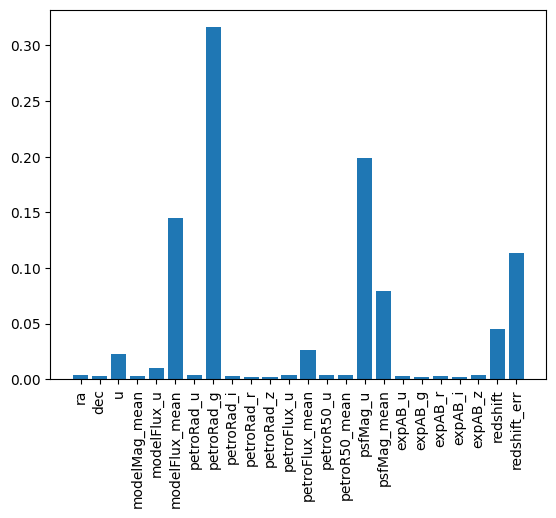

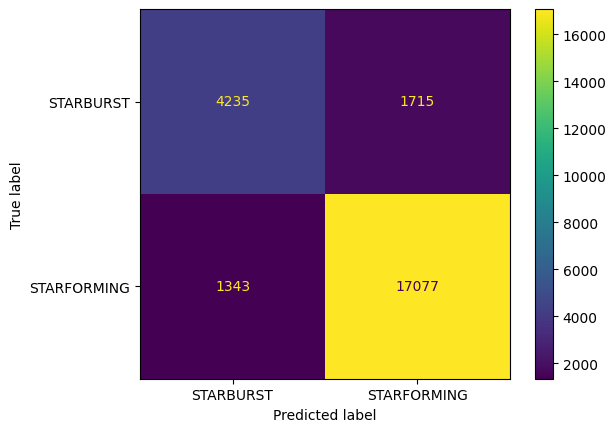

In [335]:
print_classification_report(trained_decision_tree, testing_inputs, testing_classes, "decision_tree.png")

## K-NN: Nearest Neighbour

In [336]:
nearest_neighbour = KNeighborsClassifier(
    **best_params["KNN"]
)

trained_nearest_neighbour = train_classifier(
    nearest_neighbour,
    training_inputs_over_sampl_normalized,
    training_classes_over_sampl_normalized,
)

# trained_nearest_neighbour = train_classifier(
#     nearest_neighbour,
#     training_inputs_under_sampl_normalized,
#     training_classes_under_sampl_normalized,
# )

Classifier trained


              precision    recall  f1-score   support

   STARBURST       0.86      0.98      0.91     18205
 STARFORMING       0.98      0.84      0.90     18554

    accuracy                           0.91     36759
   macro avg       0.92      0.91      0.91     36759
weighted avg       0.92      0.91      0.91     36759



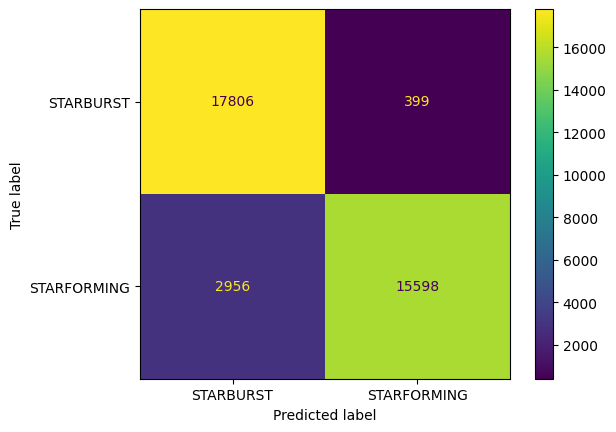

In [337]:
# print_classification_report(trained_nearest_neighbour, testing_inputs_under_sampl_normalized, testing_classes_under_sampl_normalized, "nearest_neighbour.png", False)
print_classification_report(trained_nearest_neighbour, testing_inputs_over_sampl_normalized, testing_classes_over_sampl_normalized, "nearest_neighbour.png", False)

## SVM: Support Vector Machine

In [338]:
svm = SVC(
    max_iter=100000,
    **best_params["SVM"]
)

trained_svm = train_classifier(
    svm,
    training_inputs_over_sampl_normalized,
    training_classes_over_sampl_normalized,
)

# trained_svm = train_classifier(
#     svm,
#     training_inputs_under_sampl_normalized,
#     training_classes_under_sampl_normalized,
# )

Classifier trained


C:\Users\Clara\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


              precision    recall  f1-score   support

   STARBURST       0.87      0.90      0.89     18205
 STARFORMING       0.90      0.87      0.89     18554

    accuracy                           0.89     36759
   macro avg       0.89      0.89      0.89     36759
weighted avg       0.89      0.89      0.89     36759



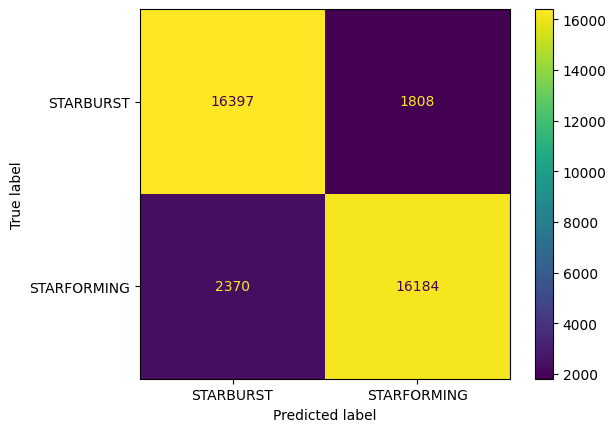

In [339]:
# print_classification_report(trained_svm, testing_inputs_under_sampl_normalized, testing_classes_under_sampl_normalized, "svm.png", False)
print_classification_report(trained_svm, testing_inputs_over_sampl_normalized, testing_classes_over_sampl_normalized, "svm.png", False)

## Redes Neuronais

In [340]:
neural_networks = MLPClassifier(
    **best_params["Neural Network"]
)

trained_neural_networks = train_classifier(
    neural_networks,
    training_inputs_over_sampl_normalized,
    training_classes_over_sampl_normalized,
)

# trained_neural_networks = train_classifier(
#     neural_networks,
#     training_inputs_under_sampl_normalized,
#     training_classes_under_sampl_normalized,
# )

              precision    recall  f1-score   support

   STARBURST       0.87      0.90      0.88     18262
 STARFORMING       0.90      0.86      0.88     18497

    accuracy                           0.88     36759
   macro avg       0.88      0.88      0.88     36759
weighted avg       0.88      0.88      0.88     36759



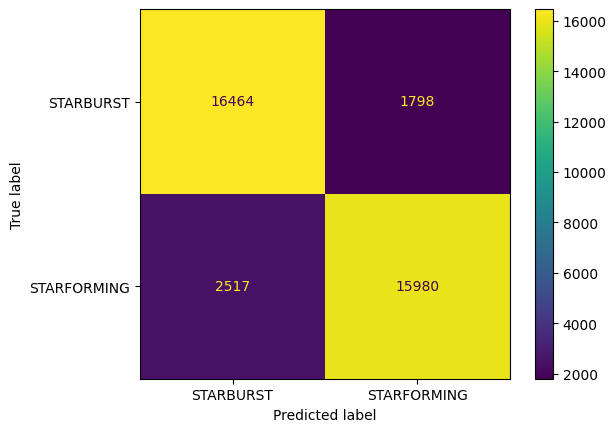

<Figure size 640x480 with 0 Axes>

In [ ]:
# print_classification_report(trained_neural_networks,
#     testing_inputs_under_sampl_normalized,
#     testing_classes_under_sampl_normalized,
#     "neural_networks.png",
#     False
# )

print_classification_report(
    trained_neural_networks,
    testing_inputs_over_sampl_normalized,
    testing_classes_over_sampl_normalized,
    "neural_networks.png",
    False
)

## Random Forest

In [ ]:
random_forest = RandomForestClassifier(
    **best_params["Random Forest"]
)

trained_random_forest = train_classifier(
    random_forest,
    training_inputs,
    training_classes,
)

Classifier trained


              precision    recall  f1-score   support

   STARBURST       0.83      0.70      0.76      6027
 STARFORMING       0.91      0.95      0.93     18343

    accuracy                           0.89     24370
   macro avg       0.87      0.82      0.84     24370
weighted avg       0.89      0.89      0.89     24370



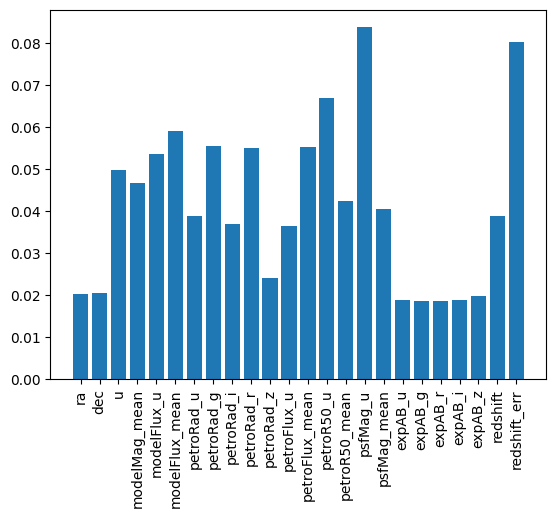

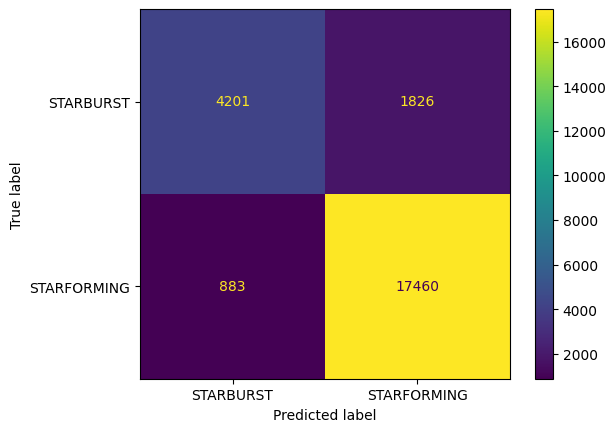

<Figure size 640x480 with 0 Axes>

In [ ]:
print_classification_report(trained_random_forest, testing_inputs, testing_classes, "random_forest.png")